# API Entry Points — Report

This notebook visualizes the CSV outputs generated by the **API_Entry_Points** block.

## What this notebook shows
- **Main_Classes**: distribution of `visibility`, `static` vs. `non-static`, top classes by frequency, signatures.
- **Spring_Controller**: controllers per stereotype (Controller / RestController), top controllers.
- **Spring_Endpoints**: sunburst for `controller → httpMethod → endpoint`, HTTP method distribution, endpoints per controller.

> If a CSV is missing or empty, the cell prints an info message and skips the chart.


In [1]:
# Setup: imports, paths, helpers
# - Keep plotting logic intact; only path resolution is simplified and standardized.
# - CSVs live under ../reports/csv-reports/<CATEGORY>/<file>.csv relative to this notebook folder.
# - Minimal console output; only show information if a CSV is missing/empty.

import os
from pathlib import Path
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import textwrap

# Base folders and category for this notebook
CATEGORY = "API_Entry_Points"
CSV_BASE = Path("../reports/csv-reports").resolve()
API_DIR = CSV_BASE / CATEGORY

# Avoid downcasting warnings when masking NAs
pd.set_option('future.no_silent_downcasting', True)

def read_csv_safe(path: Path) -> pd.DataFrame:
    """Read a CSV if present; otherwise return an empty DataFrame.
    Prints a minimal info message when missing or unreadable."""
    path = Path(path)
    if not path.exists():
        print(f"[info] Missing CSV: {path}")
        return pd.DataFrame()
    try:
        df = pd.read_csv(path)
        df.columns = [str(c).strip() for c in df.columns]
        return df
    except Exception as e:
        print(f"[warn] Failed to read {path}: {e}")
        return pd.DataFrame()

def show_head(df: pd.DataFrame, n: int = 8):
    """Display a quick head for ad‑hoc inspection; silent if empty."""
    if df.empty:
        print("[info] DataFrame is empty.")
    else:
        display(df.head(n))

def shorten_label(s: str, maxlen: int = 40) -> str:
    s = str(s)
    return (s[:maxlen-1] + "…") if len(s) > maxlen else s

def wrap_label_html(s: str, width: int = 28) -> str:
    return "<br>".join(textwrap.wrap(str(s), width=width))

def fillna_safe(series, value):
    """Mask NA values with a given literal without triggering downcast warnings."""
    s = series.copy()
    s = s.mask(s.isna(), value)
    return s


## 1) Main Classes

,mainClass,isStatic,visibility,signature,Source Cypher File: API_Entry_Points/Main_Classes.cypher
0,com.salesmanager.shop.application.ShopApplication,True,public,void main(java.lang.String[]),NaN


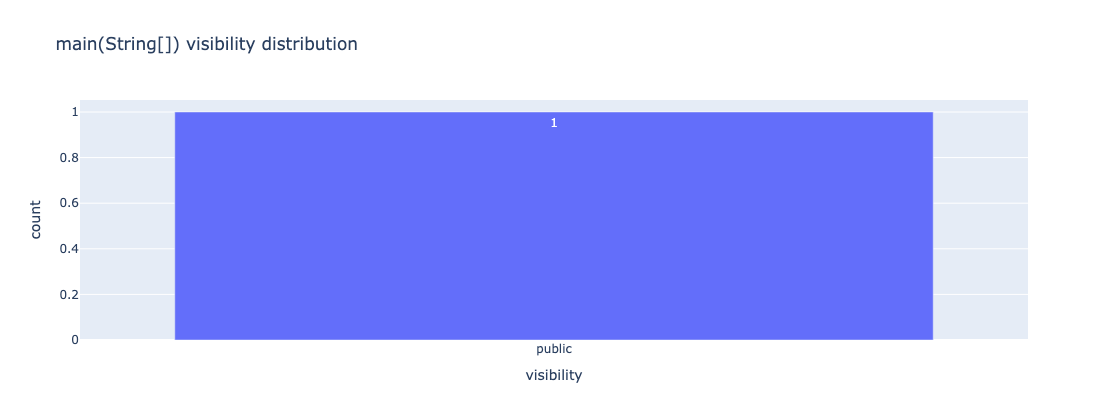

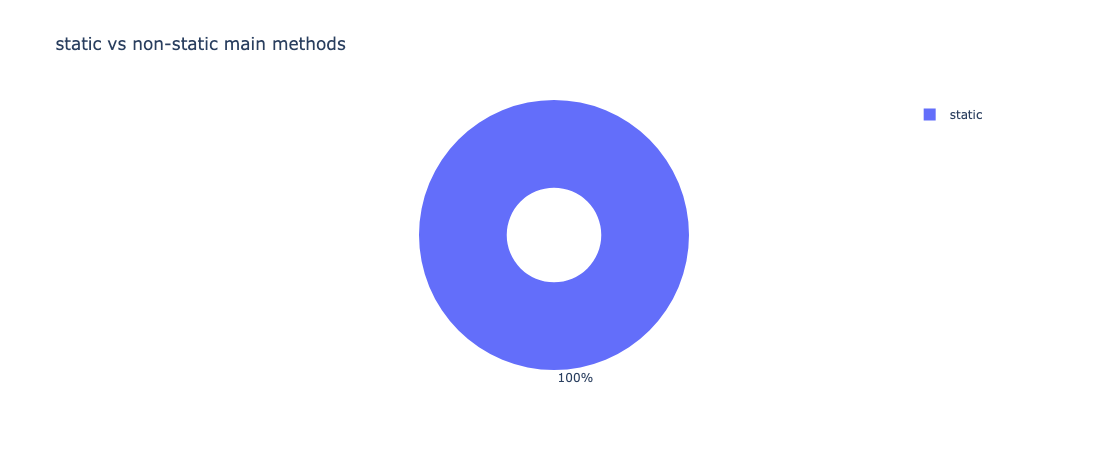

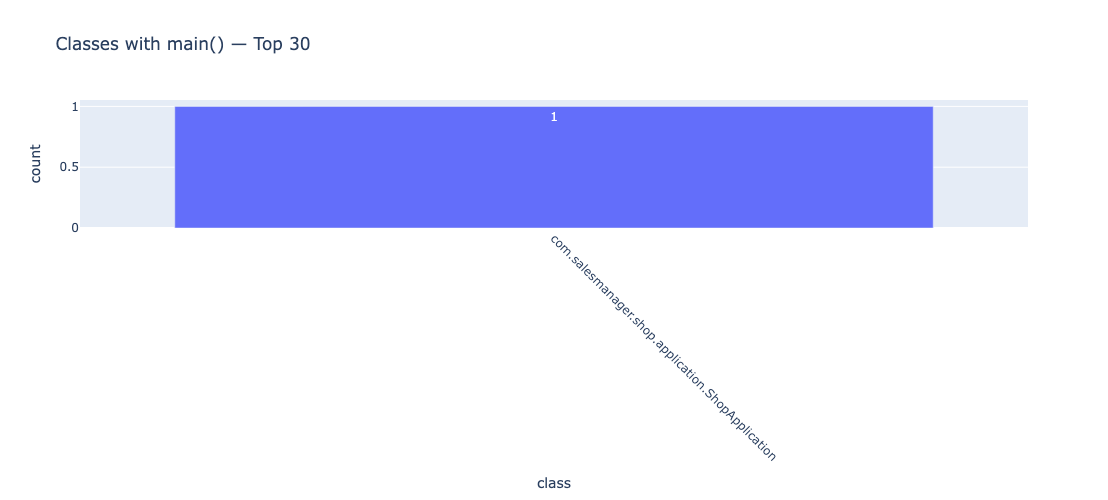

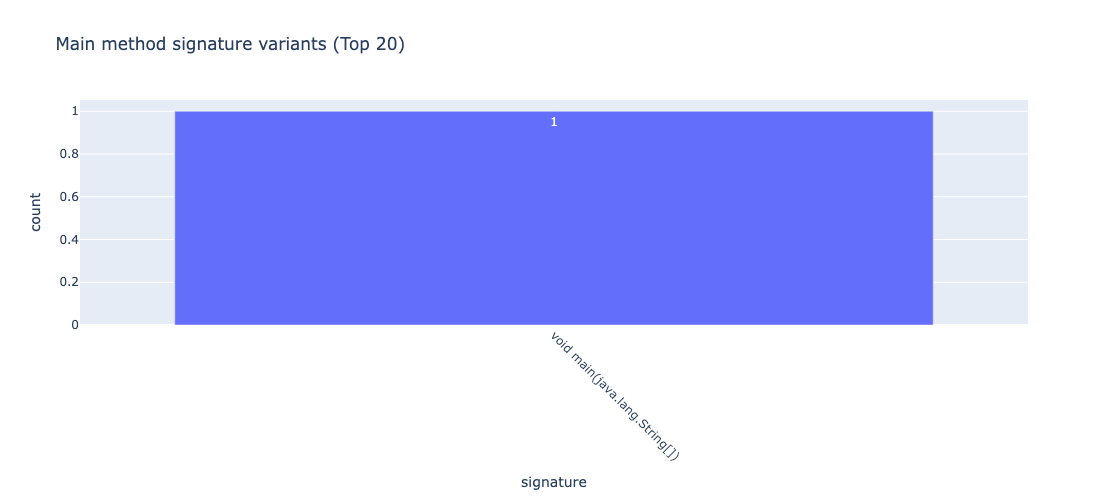

In [ ]:
# Charts for Main_Classes
# Where charts are generated:
#  - 1A) Visibility distribution (bar)
#  - 1B) static vs non-static (pie)
#  - 1C) Top classes exposing main() (bar)
#  - 1D) Signature variants (bar)

# Expected columns: mainClass, isStatic, visibility, signature
path = API_DIR / "Main_Classes.csv"
df_main = read_csv_safe(path)
show_head(df_main)

if not df_main.empty:
    cols = {c.lower(): c for c in df_main.columns}
    c_main = cols.get("mainclass")
    c_static = cols.get("isstatic")
    c_vis = cols.get("visibility")
    c_sig = cols.get("signature")
    
    # 1A) Visibility distribution
    if c_vis:
        vis_counts = fillna_safe(df_main[c_vis], "unknown").astype(str).value_counts().reset_index()
        vis_counts.columns = ["visibility", "count"]
        fig = px.bar(vis_counts, x="visibility", y="count",
                     title="main(String[]) visibility distribution", text_auto=True)
        fig.update_layout(width=900, height=420, xaxis_title="visibility", yaxis_title="count")
        fig.show()
    else:
        print("[info] Column 'visibility' not found — skipping visibility chart.")
    
    # 1B) Static vs non-static
    if c_static:
        stat = fillna_safe(df_main[c_static], False).map(lambda x: "static" if bool(x) else "non-static")
        stat_counts = stat.value_counts().reset_index()
        stat_counts.columns = ["kind", "count"]
        fig = px.pie(stat_counts, names="kind", values="count",
                     title="static vs non-static main methods", hole=0.35)
        fig.update_layout(width=700, height=450)
        fig.update_traces(textposition="outside")
        fig.show()
    else:
        print("[info] Column 'isStatic' not found — skipping static/non-static chart.")
    
    # 1C) Top classes exposing main()
    if c_main:
        top_classes = df_main[c_main].astype(str).value_counts().reset_index()
        top_classes.columns = ["className", "count"]
        fig = px.bar(top_classes.head(30), x="className", y="count",
                     title="Classes with main() — Top 30", text_auto=True)
        fig.update_layout(width=1100, height=500, xaxis_tickangle=45, xaxis_title="class", yaxis_title="count")
        fig.show()
    else:
        print("[info] Column 'mainClass' not found — skipping top classes chart.")
    
    # 1D) Signature variants
    if c_sig:
        sig_counts = fillna_safe(df_main[c_sig], "unknown").astype(str).value_counts().reset_index()
        sig_counts.columns = ["signature", "count"]
        fig = px.bar(sig_counts.head(20), x="signature", y="count",
                     title="Main method signature variants (Top 20)", text_auto=True)
        fig.update_layout(width=1100, height=500, xaxis_tickangle=45, xaxis_title="signature", yaxis_title="count")
        fig.show()
    else:
        print("[info] Column 'signature' not found — skipping signature chart.")
else:
    print("[info] Main_Classes.csv missing or empty.")

## 2) Spring Controllers

In [3]:
# Charts for Spring_Controller
# Where charts are generated:
#  - 2A) Controller stereotypes (pie)
#  - 2B) Top Controllers (bar)

# Expected columns: ControllerClassFqn, Package (stereotype fqns)
path = API_DIR / "Spring_Controller.csv"
df_ctrl = read_csv_safe(path)
show_head(df_ctrl)

if not df_ctrl.empty:
    cols = {c.lower(): c for c in df_ctrl.columns}
    c_cls = cols.get("controllerclassfqn") or cols.get("controller") or cols.get("classname")
    c_pkg = cols.get("package")
    
    # 2A) Stereotype distribution
    if c_pkg:
        simp = df_ctrl[c_pkg].astype(str).map(lambda s: s.split(".")[-1] if "." in s else s)
        pkg_counts = simp.value_counts().reset_index()
        pkg_counts.columns = ["stereotype", "count"]
        fig = px.pie(pkg_counts, names="stereotype", values="count",
                     hole=0.35, title="Controller stereotypes")
        fig.update_layout(width=700, height=450)
        fig.update_traces(textposition="outside")
        fig.show()
    else:
        print("[info] Column 'Package' not found — skipping stereotype pie.")
    
    # 2B) Top Controllers
    if c_cls:
        ctrl_counts = df_ctrl[c_cls].astype(str).value_counts().reset_index()
        ctrl_counts.columns = ["controller", "count"]
        fig = px.bar(ctrl_counts.head(30), x="controller", y="count",
                     title="Controllers — Top 30", text_auto=True)
        fig.update_layout(width=1100, height=500, xaxis_tickangle=45, xaxis_title="controller", yaxis_title="count")
        fig.show()
    else:
        print("[info] Column 'ControllerClassFqn' not found — skipping top controllers chart.")
else:
    print("[info] Spring_Controller.csv missing or empty.")


,ControllerClassFqn,Package,Source Cypher File: API_Entry_Points/Spring_Controller.cypher
0,com.salesmanager.shop.controller.ImagesController,org.springframework.stereotype.Controller,NaN
1,com.salesmanager.shop.controller.FilesController,org.springframework.stereotype.Controller,NaN
2,com.salesmanager.shop.store.api.v1.order.Order...,org.springframework.stereotype.Controller,NaN
3,com.salesmanager.shop.store.api.v1.order.Order...,org.springframework.stereotype.Controller,NaN
4,com.salesmanager.shop.store.api.v1.order.Order...,org.springframework.stereotype.Controller,NaN
5,com.salesmanager.shop.store.api.v1.user.Authen...,org.springframework.stereotype.Controller,NaN
6,com.salesmanager.shop.store.api.v1.product.Pro...,org.springframework.stereotype.Controller,NaN
7,com.salesmanager.shop.store.api.v1.product.Pro...,org.springframework.stereotype.Controller,NaN


## 3) Spring Endpoints

,controller,method,httpMethod,completeEndpoint,Source Cypher File: API_Entry_Points/Spring_Endpoints.cypher
0,com.salesmanager.shop.controller.FilesController,downloadFile,RequestMapping,/static/files/{storeCode}/{fileName}.{extension},NaN
1,com.salesmanager.shop.controller.FilesController,downloadProduct,RequestMapping,/admin/files/downloads/{storeCode}/{fileName}....,NaN
2,com.salesmanager.shop.controller.ImagesController,printImage,RequestMapping,/static/products/{storeCode}/{productCode}/{im...,NaN
3,com.salesmanager.shop.controller.ImagesController,printImage,RequestMapping,/static/files/{storeCode}/{imageType}/{imageNa...,NaN
4,com.salesmanager.shop.controller.ImagesController,printImage,RequestMapping,/static/{storeCode}/{imageType}/{productCode}/...,NaN
5,com.salesmanager.shop.controller.ImagesController,printImage,RequestMapping,/static/products/{storeCode}/{productCode}/{im...,NaN
6,com.salesmanager.shop.store.api.DefaultController,version,GetMapping,/,NaN
7,com.salesmanager.shop.store.api.exception.Rest...,handleRestApiException,RequestMapping,NaN,NaN


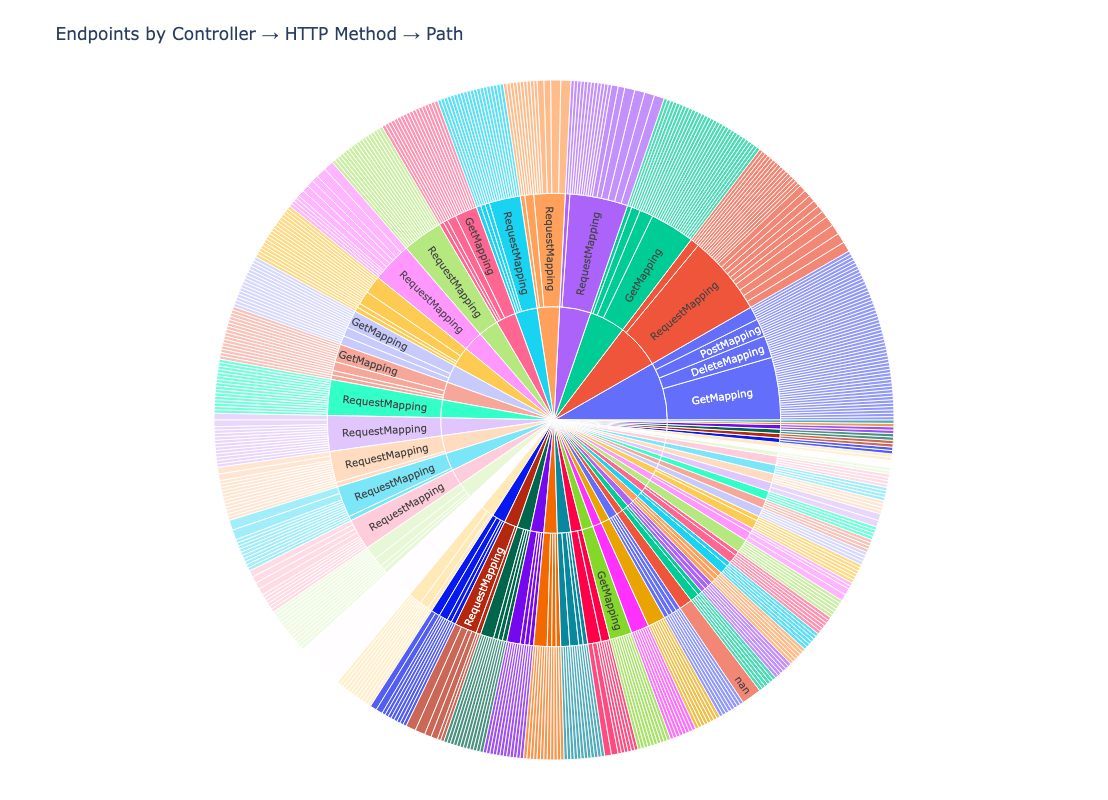

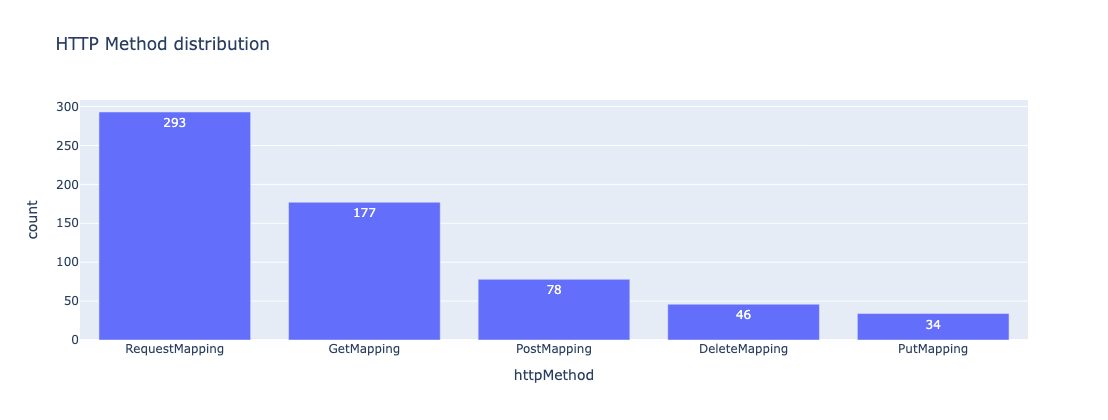

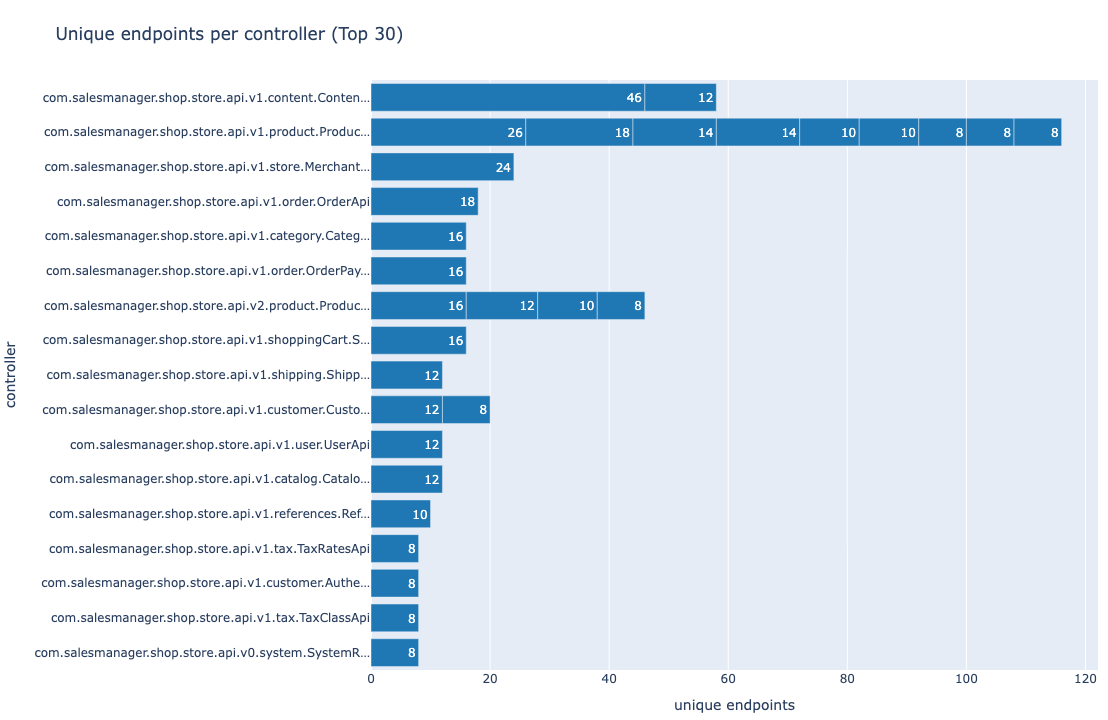

In [7]:
# Charts for Spring_Endpoints
# Where charts are generated:
#  - 3A) Sunburst: Controller → HTTP Method → Path
#  - 3B) HTTP Method distribution (bar)
#  - 3C) Unique endpoints per controller (horizontal bar)

# Expected columns: controller, method, httpMethod, completeEndpoint
path = API_DIR / "Spring_Endpoints.csv"
df_ep = read_csv_safe(path)
show_head(df_ep)

if not df_ep.empty:
    cols = {c.lower(): c for c in df_ep.columns}
    c_ctrl = cols.get("controller")
    c_meth = cols.get("method")
    c_http = cols.get("httpmethod") or cols.get("httprequestmethod") or cols.get("methodtype")
    c_path = cols.get("completeendpoint") or cols.get("path") or cols.get("endpoint")
    
    if c_ctrl: df_ep[c_ctrl] = df_ep[c_ctrl].astype(str)
    if c_meth: df_ep[c_meth] = df_ep[c_meth].astype(str)
    if c_http: df_ep[c_http] = df_ep[c_http].astype(str)
    if c_path: df_ep[c_path] = df_ep[c_path].astype(str)
    
    # 3A) Sunburst large
    if c_ctrl and c_http and c_path:
        sub = df_ep[[c_ctrl, c_http, c_path]].copy()
        fig = px.sunburst(sub, path=[c_ctrl, c_http, c_path],
                          maxdepth=3, title="Endpoints by Controller → HTTP Method → Path")
        fig.update_layout(width=1200, height=800,
                          margin=dict(l=40, r=40, t=80, b=40),
                          uniformtext_minsize=10, uniformtext_mode='hide')
        fig.show()
    else:
        print("[info] Missing one of [controller, httpMethod, completeEndpoint] — skipping sunburst.")
    
    # 3B) HTTP method distribution
    if c_http:
        method_counts = df_ep[c_http].mask(df_ep[c_http].isna(), "unknown").value_counts().reset_index()
        method_counts.columns = ["httpMethod", "count"]
        fig = px.bar(method_counts, x="httpMethod", y="count",
                     title="HTTP Method distribution", text_auto=True)
        fig.update_layout(width=900, height=420, xaxis_title="httpMethod", yaxis_title="count")
        fig.show()
    else:
        print("[info] Column 'httpMethod' not found — skipping HTTP method distribution.")
    
    # 3C) Endpoints per controller (Top 30) — horizontal + dynamic height + hover full
    if c_ctrl and c_path:
        per_ctrl = (
            df_ep.groupby(c_ctrl)[c_path]
                .nunique()
                .reset_index()
                .sort_values(c_path, ascending=False)
                .head(30)
        )
        per_ctrl.columns = ["controller", "uniqueEndpoints"]
        per_ctrl["controller_short"] = per_ctrl["controller"].map(lambda s: shorten_label(s, 50))
        h = max(600, 24 * len(per_ctrl))
        fig = px.bar(per_ctrl, x="uniqueEndpoints", y="controller_short",
                     orientation="h", title="Unique endpoints per controller (Top 30)", text_auto=True, color_discrete_sequence=["#1f77b4"])
        fig.update_layout(height=h, width=1100, xaxis_title="unique endpoints", yaxis_title="controller",
                          yaxis=dict(autorange="reversed"), margin=dict(l=10, r=10, t=80, b=10))
        fig.update_traces(hovertemplate="<b>%{customdata[0]}</b><br>unique endpoints: %{x}<extra></extra>",
                          customdata=np.stack([per_ctrl['controller']], axis=-1))
        fig.show()
    else:
        print("[info] Missing controller/path — skipping endpoints per controller.")
else:
    print("[info] Spring_Endpoints.csv missing or empty.")
